In [1]:
import numpy as np
import pandas as pd
import sys
import os
import csv
import ipdb
import pickle
from collections import OrderedDict, defaultdict
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [6]:
CONFIG = {
    'week': 'week12',
    'current_week': 12
    # 'calling_list': sys.argv[2],
    # 'round_robin_list': sys.argv[3]
}
policies = ['rmab', 'control', 'round_robin']
T = 12

df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')


In [9]:
df2 = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')


rmab_list = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')['user_id'].to_list()
round_robin_list = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')['user_id'].to_list()
control_list = pd.read_csv('outputs/pilot_outputs/control_pilot.csv')['user_id'].to_list()


rmab_group = df[df['user_id'].isin(rmab_list)]
# rmab_group = rmab_group[rmab_group['user_id'].isin(intervened_ppl)]
rmab_group = rmab_group.sort_values('{}_whittle'.format(CONFIG['week']), ascending=False)

round_robin_group = df2[df2['user_id'].isin(round_robin_list)]
# round_robin_group = round_robin_group[round_robin_group['user_id'].isin(intervened_ppl)]
round_robin_group = round_robin_group.sort_values('registration_date', ascending=True)

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

In [178]:
intervention_benefit = {'rmab': [], 'round_robin': [], 'control': []}

all_user_ids = set(df['user_id'].to_list())

full_mat = {'rmab': [], 'round_robin': [], 'control': []}

with open('policy_dump.pkl', 'rb') as fr:
    pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

arm_to_cat = {'rmab': [1,0], 'round_robin': [0,1], 'control': [0,0]}


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [199]:
pilot_pd_data = pd.read_csv("feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv", sep='\t')
class_based_features = ['ChannelType', 'phone_owner' , "call_slots", "language"]
numeric_features = ['enroll_gest_age', "enroll_delivery_status", 
                    'age_binned', 'g', 'p', 's', 'l', 'a', 'education', 'income_binned']

pilot_pd_data['income_binned'] = pilot_pd_data['income_bracket'].replace(
    dict(zip(['0-5000', '5000-10000', '10000-15000', '15000-20000',
        '20000-25000', '25000-30000', '30000 and above'], [0,1,2,3,4,5,6])))
pilot_pd_data['age_binned'] = pd.cut(pilot_pd_data['age'], bins=5, labels=False)


dummy = pd.get_dummies(pilot_pd_data[class_based_features], columns = class_based_features)
pilot_pd_data = pd.concat([pilot_pd_data.drop(columns = class_based_features), dummy], axis=1)
class_based_features = list(dummy.columns)

pilot_pd_data[numeric_features+class_based_features]



,enroll_gest_age,enroll_delivery_status,age_binned,g,p,s,l,a,education,income_binned,...,phone_owner_woman,call_slots_1,call_slots_2,call_slots_3,call_slots_4,call_slots_5,call_slots_6,language_2,language_3,language_5
0,13,0,0,2,1,0.0,1,0,2,1,...,1,0,0,1,0,0,0,1,0,0
1,14,0,0,1,0,0.0,0,0,3,1,...,1,0,0,1,0,0,0,1,0,0
2,8,0,0,1,0,0.0,0,0,2,1,...,1,0,0,0,0,0,1,0,1,0
3,11,0,1,2,1,0.0,1,0,4,1,...,1,0,0,1,0,0,0,0,1,0
4,31,0,1,3,2,0.0,2,0,7,1,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,8,0,1,3,0,0.0,0,2,3,1,...,1,1,0,0,0,0,0,0,1,0
23523,39,0,0,1,0,0.0,0,0,5,2,...,1,0,0,1,0,0,0,1,0,0
23524,26,0,0,2,1,0.0,1,0,4,1,...,1,0,0,1,0,0,0,1,0,0
23525,21,0,1,1,0,0.0,0,0,3,1,...,1,0,0,0,1,0,0,1,0,0


In [200]:
columns = numeric_features+class_based_features +["curr_state"] +["exp_arm_rmab","exp_arm_rr"]
pilot_user_ids = df.user_id
pilot_static_features = pilot_pd_data[pilot_pd_data['user_id'].isin(pilot_user_ids)][numeric_features+class_based_features+['user_id']]
# pilot_static_features = pilot_pd_data[pilot_pd_data['user_id'].isin(pilot_user_ids)][numeric_features+class_based_features].values


pilot_static_features = pilot_static_features.set_index('user_id')
pilot_static_features = pilot_static_features.loc[pilot_user_ids].values


In [201]:
X_mat, Y_mat, Y_all_mat, C_mat = [], [[] for i in range(1,13)], [[] for i in range(1,13)], [[] for i in range(1,13)]

mask = {'rmab':[0]*len(pilot_user_ids), 'round_robin':[0]*len(pilot_user_ids), 'control':[0]*len(pilot_user_ids)}
ctr = 0
for idx, user_id in tqdm(enumerate(pilot_user_ids)):
    if user_id not in all_user_ids:
        continue
#     print(user_id)
    curr_mat = []
    curr_row = df[df['user_id'] == user_id]

    # check_row = df_check[df_check['user_id'] == user_id]

    arm = curr_row['arm'].item()
    count_all = 0
    count_bin = 0
    count_c = 0

    week0e, week0c = [int(itr) for itr in curr_row['week{}_E/C'.format(0)].item().split('/')]
    count_c += week0c
    if week0e:
        curr_mat.append(1)
        count_all += week0e
        count_bin += 1
    else:
        curr_mat.append(0)
#     print('week0', curr_row['week{}_E/C'.format(0)].item(), count, count_c)
    Y_mat[0].append(count_bin)
    Y_all_mat[0].append(count_all)
    C_mat[0].append(count_c)
    for i in range(1,12):
        nume, numc = [int(itr) for itr in curr_row['week{}_E/C'.format(i)].item().split('/')]
        count_c += numc
        if nume > 0:
            count_all += nume
            count_bin += 1
            curr_mat.append(nume)
        else:
            curr_mat.append(0)
#         print(f'week{i}', curr_row['week{}_E/C'.format(i)].item(), count, count_c)
        Y_mat[i].append(count_bin)
        Y_all_mat[i].append(count_all)
        C_mat[i].append(count_c)
#     X_mat.append(list(pilot_static_features[idx, :]) + [curr_mat[0]] + arm_to_cat[arm])
    X_mat.append(list(pilot_static_features[idx, :]) + [curr_mat[0]]+ arm_to_cat[arm])

    mask[arm][ctr] = 1
    ctr+=1

    full_mat[arm].append(np.array(curr_mat, dtype=np.int))

mask = {i:np.array(mask[i][:ctr]) for i in mask}
X_mat = np.array(X_mat)
Y_mat = np.array(Y_mat)
Y_all_mat = np.array(Y_all_mat)
C_mat = np.array(C_mat)


23003it [00:22, 1034.41it/s]


In [202]:
#  0 eng, 3 eng, 2 eng -> 0, 1, 1 -> 0, 1, 2
    
#     e(t) = 0 or 1 
# c(t) = sigma(e(t)) t = 1, T

# Y_all_mat -> 0, 3, 2 -> 0, 3, 5

# C_mat -> 0, 5, 3 -> 0, 5, 8


### Thresholding Viz

In [400]:
thresh = 0.7

Y_thresh_mat = (Y_all_mat > C_mat*thresh).astype(int)


Text(0, 0.5, '# beneficiries with greater than 50% listenership')

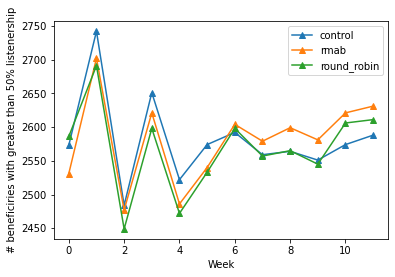

In [401]:
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(12), [(Y_all_mat[week][mask[pol]==1]>(C_mat[week][mask[pol]==1])*thresh).astype(int).sum()\
#                          - (Y_all_mat[0][mask[pol]==1]>(C_mat[0][mask[pol]==1])*thresh).astype(int).sum()\
                         for week in range(12)],
             '-^', label=pol)
plt.legend()
plt.xlabel('Week')
plt.ylabel('# beneficiries with greater than 50% listenership')

Text(0, 0.5, '# beneficiries with greater than 50% listenership')

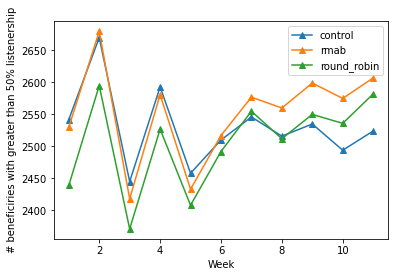

In [402]:
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(1, 12), [((Y_all_mat[week][mask[pol]==1]- Y_all_mat[0][mask[pol]==1])>\
                           (C_mat[week][mask[pol]==1]-C_mat[0][mask[pol]==1])*thresh).astype(int).sum()\
                         for week in range(1, 12)],
             '-^', label=pol)
plt.legend()
plt.xlabel('Week')
plt.ylabel('# beneficiries with greater than 50% listenership')

In [ ]:
## thresholding on 3 and above
## 

In [166]:
Y_thresh_mat[5][mask['rmab']==1].sum(), Y_thresh_mat[5][mask['rmab']==1].mean(), Y_thresh_mat[5][mask['rmab']==1].std()

(3185, 0.4153625456442358, 0.492784436970341)

(array([4483.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3185.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

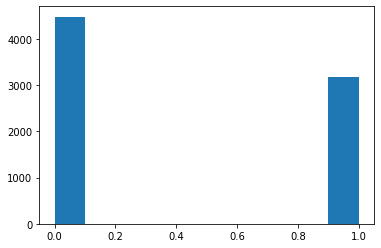

In [167]:
plt.hist(Y_thresh_mat[5][mask['rmab']==1])

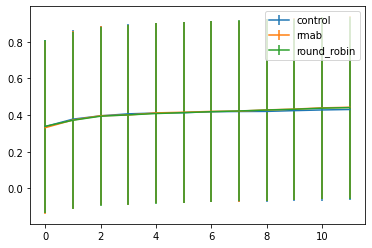

In [375]:
# thresh = 0.5
for pol in ['control' , 'rmab','round_robin' ]:
    plt.errorbar(range(12), [(Y_all_mat[week][mask[pol]==1]>(C_mat[week][mask[pol]==1])*thresh).astype(int).mean()\
#                          - (Y_all_mat[0][mask[pol]==1]>(C_mat[0][mask[pol]==1])*thresh).astype(int).mean()\
                         for week in range(12)],
                 yerr=[((Y_all_mat[week][mask[pol]==1]>(C_mat[week][mask[pol]==1])*thresh).astype(int)\
#                          - (Y_all_mat[0][mask[pol]==1]>(C_mat[0][mask[pol]==1])*thresh).astype(int)\
                       ).std()\
                         for week in range(12)],
             label=pol)
plt.legend()

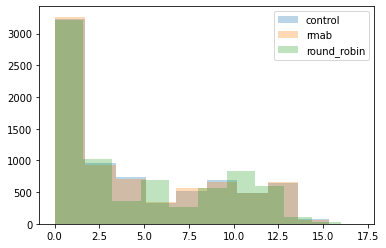

In [149]:
for pol in ['control' , 'rmab','round_robin' ]:
    plt.hist(Y_all_mat[5][mask[pol]==1] , label=pol, alpha=0.3)
plt.legend()
# Y_all_mat[5][mask[pol]==1].mean(), Y_all_mat[5][mask[pol]==1].std()

### Intervention subset

In [217]:
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')

interv_df = pd.DataFrame(columns=['user_id', 'intervene_week', 'intervene_date', 'exp_group'])
interv_calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721']

from datetime import datetime
week_date_lookup = {int(f.split('_')[1].split('week')[-1]):datetime.strptime(f.split('_')[-1], '%d%m%y') for f in interv_calling_files}

for file in interv_calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            interv_week = int(file.split('_')[1].split('week')[-1])
            exp_group = df[df['user_id']==user_id]['arm'].iloc[0]
            intervene_date = week_date_lookup[interv_week]
            interv_df = interv_df.append({'user_id': user_id, 'intervene_week': interv_week, 'intervene_date':intervene_date, 'exp_group': exp_group}, ignore_index=True)
interv_df = pd.merge(interv_df, reg[['user_id', 'registration_date']])  
interv_df = pd.merge(interv_df, df[['user_id', 'cluster']])
interv_df['registration_date'] = pd.to_datetime(interv_df['registration_date'])
interv_df['days_since_reg'] = (interv_df['intervene_date'] - interv_df['registration_date']).dt.days


In [218]:
interv_df

,user_id,intervene_week,intervene_date,exp_group,registration_date,cluster,days_since_reg
0,2393699,1,2021-04-29,rmab,2021-02-25,1,63
1,2387277,1,2021-04-29,round_robin,2021-02-01,10,87
2,2401025,1,2021-04-29,rmab,2021-03-03,1,57
3,2401025,3,2021-05-12,rmab,2021-03-03,1,70
4,2401025,4,2021-05-18,rmab,2021-03-03,1,76
...,...,...,...,...,...,...,...
7180,2395228,11,2021-07-05,round_robin,2021-02-22,16,133
7181,2395195,11,2021-07-05,round_robin,2021-02-23,35,132
7182,2392191,11,2021-07-05,round_robin,2021-02-22,16,133
7183,2394510,11,2021-07-05,round_robin,2021-02-23,35,132


In [265]:
week_list = [i for i in range(1, 6)]
sub = interv_df[interv_df['intervene_week'].isin(week_list)]
sub[~sub['user_id'].duplicated()]['exp_group'].value_counts()

round_robin    889
rmab           888
Name: exp_group, dtype: int64

In [351]:
X_mat_df = pd.DataFrame(X_mat, columns=columns)
interv_X_mat_df = X_mat_df.copy()
interv_X_mat_df['user_id'] = pilot_user_ids
interv_df['first_interv_week'] = interv_df.groupby('user_id')['intervene_week'].transform(min)
interv_df = interv_df[['user_id', 'first_interv_week']].drop_duplicates()
interv_X_mat_df = pd.merge(interv_X_mat_df, interv_df, how='left', on='user_id')
interv_X_mat_df['first_interv_week'] = interv_X_mat_df['first_interv_week'].fillna(999)

interv_X_mat_df.shape
# X_mat_df['is_intervened_week3'] =  pd.apply(X_mat_d

(23003, 31)

In [357]:
for i in range(1, 12):
    interv_X_mat_df[f'is_intervened_by_week{i}'] = (interv_X_mat_df['first_interv_week']<i).astype(int)

In [223]:
columns

['enroll_gest_age',
 'enroll_delivery_status',
 'age_binned',
 'g',
 'p',
 's',
 'l',
 'a',
 'education',
 'income_binned',
 'ChannelType_ARMMAN',
 'ChannelType_Community',
 'ChannelType_Hospital',
 'phone_owner_family',
 'phone_owner_husband',
 'phone_owner_neighbor ',
 'phone_owner_woman',
 'call_slots_1',
 'call_slots_2',
 'call_slots_3',
 'call_slots_4',
 'call_slots_5',
 'call_slots_6',
 'language_2',
 'language_3',
 'language_5',
 'curr_state',
 'exp_arm_rmab',
 'exp_arm_rr']

### Linear Regression Test

In [370]:
print('With Feat Reduction and Intervention Flag')
def variance_threshold_selector(data, threshold=0.0001):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

for t in range(1, 10):
    print(f'Significance for T = {t}')
    print('\tRMAB vs RR')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-Y_mat[0][mask['control']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['control']==0]\
#                             -Y_thresh_mat[0][mask['control']==0]\
                            , columns = ['output'])
    test_X_mat_df = X_mat_df.drop(columns="exp_arm_rr")[mask['control']==0]
    test_X_mat_df[f'is_intervened_by_week{t}'] = interv_X_mat_df[f'is_intervened_by_week{t}']
    test_X_mat_df.index = np.array(Y_mat_df.index)
    test_X_mat_df = variance_threshold_selector(sm.add_constant(test_X_mat_df))
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df, test_X_mat_df)
    fii = mod.fit()
    index = list(test_X_mat_df.columns).index('exp_arm_rmab')
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
    print(f'\t exp: Coef: {coef}, p_val: {p_val}')
    try:
        index = list(test_X_mat_df.columns).index(f'is_intervened_by_week{t}')
        var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
        print(f'\t is_intervened_by_week{t} : Coef: {coef}, p_val: {p_val}')
    except:
        pass
    print(fii.summary().tables[1])
    print('\n')
    print('\tRMAB vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['round_robin']==0]-Y_mat[0][mask['round_robin']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['round_robin']==0]\
#                             -Y_thresh_mat[0][mask['round_robin']==0]\
                            , columns = ['output'])
    test_X_mat_df = X_mat_df.drop(columns="exp_arm_rr")[mask['round_robin']==0]
    test_X_mat_df[f'is_intervened_by_week{t}'] = interv_X_mat_df[f'is_intervened_by_week{t}']
    test_X_mat_df.index = np.array(Y_mat_df.index)
    test_X_mat_df = variance_threshold_selector(sm.add_constant(test_X_mat_df))
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df, test_X_mat_df)
    fii = mod.fit()
    index = list(test_X_mat_df.columns).index('exp_arm_rmab')
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
    print(f'\t exp: Coef: {coef}, p_val: {p_val}')
    try:
        index = list(test_X_mat_df.columns).index(f'is_intervened_by_week{t}')
        var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
        print(f'\t is_intervened_by_week{t} : Coef: {coef}, p_val: {p_val}')
    except:
        pass
    print('\n')
    print('\tRR vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['rmab']==0]-Y_mat[0][mask['rmab']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['rmab']==0]\
#                             -Y_thresh_mat[0][mask['rmab']==0]\
                            , columns = ['output'])

    test_X_mat_df = X_mat_df.drop(columns="exp_arm_rmab")[mask['rmab']==0]
    test_X_mat_df[f'is_intervened_by_week{t}'] = interv_X_mat_df[f'is_intervened_by_week{t}']
    test_X_mat_df.index = np.array(Y_mat_df.index)
    test_X_mat_df = variance_threshold_selector(sm.add_constant(test_X_mat_df))
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df, test_X_mat_df)
    fii = mod.fit()
    index = list(test_X_mat_df.columns).index('exp_arm_rr')
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
    print(f'\t exp: Coef: {coef}, p_val: {p_val}')
    try:
        index = list(test_X_mat_df.columns).index(f'is_intervened_by_week{t}')
        var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
        print(f'\t is_intervened_by_week{t} : Coef: {coef}, p_val: {p_val}')
    except:
        pass
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n\n')

With Feat Reduction and Intervention Flag
Significance for T = 1
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.339318
         Iterations 7
	 exp: Coef:     0.0775, p_val:  0.122
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0101      0.003     -3.606      0.000      -0.016      -0.005
enroll_delivery_status    -0.2559      0.087     -2.944      0.003      -0.426      -0.086
age_binned                 0.2398      0.048      5.047      0.000       0.147       0.333
g                         -0.1095      0.034     -3.185      0.001      -0.177      -0.042
p                          0.2409      0.194      1.245      0.213      -0.138       0.620
s                         -0.3564      0.247     -1.442      0.149      -0.841       0.128
l                         -0.3248      0.195     -1.67

Optimization terminated successfully.
         Current function value: 0.401271
         Iterations 6
	 exp: Coef:     0.0577, p_val:  0.220
	 is_intervened_by_week4 : Coef:     0.1991, p_val:  0.145


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.407036
         Iterations 6
	 exp: Coef:    -0.0280, p_val:  0.547
	 is_intervened_by_week4 : Coef:     0.3167, p_val:  0.019
	Coef:     0.3167, p_val:  0.019



Significance for T = 5
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.415612
         Iterations 6
	 exp: Coef:     0.0661, p_val:  0.144
	 is_intervened_by_week5 : Coef:     0.3601, p_val:  0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0087      0.003     -3.447      0.001      -0.014      -0.004
enroll_delivery_status    -0.1348      

	 exp: Coef:     0.0062, p_val:  0.894
	 is_intervened_by_week8 : Coef:     0.6039, p_val:  0.000


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.441317
         Iterations 6
	 exp: Coef:     0.0034, p_val:  0.941
	 is_intervened_by_week8 : Coef:     0.3001, p_val:  0.000
	Coef:     0.3001, p_val:  0.000



Significance for T = 9
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.445476
         Iterations 6
	 exp: Coef:     0.0735, p_val:  0.091
	 is_intervened_by_week9 : Coef:     0.5678, p_val:  0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0111      0.002     -4.551      0.000      -0.016      -0.006
enroll_delivery_status    -0.1669      0.072     -2.304      0.021      -0.309      -0.025
age_binned                 0.1473      0.041      

In [364]:
X_mat_df = X_mat_df.drop(columns = [col for col in X_mat_df.columns if col.startswith('phone_owner')]+
                        [col for col in X_mat_df.columns if col.startswith('Channel')]+
                        [col for col in X_mat_df.columns if col.startswith('call_slots')])

In [373]:

mask_cols = ['control', 'round_robin', 'rmab']
dummy_drop_cols = ['exp_arm_rr', 'exp_arm_rr', 'exp_arm_rmab']
dummy_target_cols = ['exp_arm_rmab', 'exp_arm_rmab', 'exp_arm_rr']
exps = ['RMAB vs RR', 'RMAB vs Control', 'RR vs Control']
for t in range(1, 12):
    print(f'Significance for T = {t}\n')
    for m, d, tar, e in zip(mask_cols, dummy_drop_cols, dummy_target_cols, exps):
        print(f'\t{e}')
        #     Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-Y_mat[0][mask['control']==0], columns = ['output'])
        Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask[m]==0]\
        #                             -Y_thresh_mat[0][mask['control']==0]\
                                , columns = ['output'])

        test_X_mat_df = X_mat_df.drop(columns=d)[mask[m]==0]
        test_X_mat_df[f'is_intervened_by_week{t}'] = interv_X_mat_df[f'is_intervened_by_week{t}']
        test_X_mat_df.index = np.array(Y_mat_df.index)
        test_X_mat_df = variance_threshold_selector(sm.add_constant(test_X_mat_df), 0.0001)
        #     X_mat_df = X_mat_df.drop(columns="curr_state")


        mod = sm.Logit(Y_mat_df, test_X_mat_df)
        fii = mod.fit()

        index = list(test_X_mat_df.columns).index(tar)
        var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
        print(f'\t exp: Coef: {coef}, p_val: {p_val}')

        try:
            index = list(test_X_mat_df.columns).index(f'is_intervened_by_week{t}')
            var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
            print(f'\t is_intervened_by_week{t} : Coef: {coef}, p_val: {p_val}')
        except:
            pass

#         print(fii.summary().tables[1])
        print('\n')
    print('~'*100)


Significance for T = 1

	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.339318
         Iterations 7
	 exp: Coef:     0.0775, p_val:  0.122


	RMAB vs Control
Optimization terminated successfully.
         Current function value: 0.341462
         Iterations 7
	 exp: Coef:     0.0323, p_val:  0.519


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.341465
         Iterations 7
	 exp: Coef:    -0.0422, p_val:  0.397


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Significance for T = 2

	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.368330
         Iterations 7
	 exp: Coef:     0.0824, p_val:  0.089
	 is_intervened_by_week2 : Coef:     0.2839, p_val:  0.199


	RMAB vs Control
Optimization terminated successfully.
         Current function value: 0.367210
         Iterations 7
	 exp: Coef:     0.0764, p_val:  0.116
	 is_i

In [394]:
Y_mat[8]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0,  0],
       ...,
       [ 9,  3,  3, ...,  0,  0,  4],
       [10,  3,  3, ...,  0,  0,  5],
       [11,  3,  3, ...,  0,  0,  6]])

In [346]:
Y_mat[8][mask['rmab']==0].mean(), Y_mat[8][mask['rmab']==0].std()

(3.9938050211933485, 3.557386557314504)

In [374]:

mask_cols = ['control', 'round_robin', 'rmab']
dummy_drop_cols = ['exp_arm_rr', 'exp_arm_rr', 'exp_arm_rmab']
dummy_target_cols = ['exp_arm_rmab', 'exp_arm_rmab', 'exp_arm_rr']
exps = ['RMAB vs RR', 'RMAB vs Control', 'RR vs Control']
for t in range(1, 12):
    print(f'Significance for T = {t}\n')
    for m, d, tar, e in zip(mask_cols, dummy_drop_cols, dummy_target_cols, exps):
        print(f'\t{e}')
        #     Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-Y_mat[0][mask['control']==0], columns = ['output'])
        Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask[m]==0]\
        #                             -Y_thresh_mat[0][mask['control']==0]\
                                , columns = ['output'])

        test_X_mat_df = X_mat_df.drop(columns=d)[mask[m]==0]
        test_X_mat_df[f'is_intervened_by_week{t}'] = interv_X_mat_df[f'is_intervened_by_week{t}']
        test_X_mat_df.index = np.array(Y_mat_df.index)
        test_X_mat_df = variance_threshold_selector(sm.add_constant(test_X_mat_df), 0.0001)
        #     X_mat_df = X_mat_df.drop(columns="curr_state")


        mod = sm.OLS(Y_mat_df, test_X_mat_df)
        fii = mod.fit()

        index = list(test_X_mat_df.columns).index(tar)
        var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
        print(f'\t exp: Coef: {coef}, p_val: {p_val}')

        try:
            index = list(test_X_mat_df.columns).index(f'is_intervened_by_week{t}')
            var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[index+1]
            print(f'\t is_intervened_by_week{t} : Coef: {coef}, p_val: {p_val}')
        except:
            pass

#         print(fii.summary().tables[1])
        print('\n')
    print('~'*100)


Significance for T = 1

	RMAB vs RR
	 exp: Coef:     0.0080, p_val:  0.128


	RMAB vs Control
	 exp: Coef:     0.0032, p_val:  0.541


	RR vs Control
	 exp: Coef:    -0.0048, p_val:  0.362


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Significance for T = 2

	RMAB vs RR
	 exp: Coef:     0.0089, p_val:  0.100
	 is_intervened_by_week2 : Coef:     0.0233, p_val:  0.275


	RMAB vs Control
	 exp: Coef:     0.0082, p_val:  0.131
	 is_intervened_by_week2 : Coef:     0.0046, p_val:  0.880


	RR vs Control
	 exp: Coef:    -0.0012, p_val:  0.824
	 is_intervened_by_week2 : Coef:     0.0373, p_val:  0.222


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Significance for T = 3

	RMAB vs RR
	 exp: Coef:     0.0056, p_val:  0.311
	 is_intervened_by_week3 : Coef:     0.0130, p_val:  0.349


	RMAB vs Control
	 exp: Coef:     0.0009, p_val:  0.869
	 is_intervened_by_week3 : Coef:     0.0041, p_

In [285]:
variance_threshold_selector(sm.add_constant(test_X_mat_df)).columns, test_X_mat_df.columns

(Index(['enroll_gest_age', 'enroll_delivery_status', 'age_binned', 'g', 'p',
        'l', 'education', 'income_binned', 'ChannelType_Community',
        'ChannelType_Hospital', 'phone_owner_woman', 'call_slots_1',
        'call_slots_3', 'call_slots_4', 'call_slots_5', 'call_slots_6',
        'language_2', 'language_3', 'curr_state', 'exp_arm_rr'],
       dtype='object'),
 Index(['enroll_gest_age', 'enroll_delivery_status', 'age_binned', 'g', 'p',
        's', 'l', 'a', 'education', 'income_binned', 'ChannelType_ARMMAN',
        'ChannelType_Community', 'ChannelType_Hospital', 'phone_owner_family',
        'phone_owner_husband', 'phone_owner_neighbor ', 'phone_owner_woman',
        'call_slots_1', 'call_slots_2', 'call_slots_3', 'call_slots_4',
        'call_slots_5', 'call_slots_6', 'language_2', 'language_3',
        'language_5', 'curr_state', 'exp_arm_rr', 'is_intervened_by_week6'],
       dtype='object'))

In [301]:
fii.summary().tables[1].data

[['', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'],
 ['enroll_gest_age',
  '   -0.0092',
  '    0.003',
  '   -3.258',
  ' 0.001',
  '   -0.015',
  '   -0.004'],
 ['enroll_delivery_status',
  '   -0.1674',
  '    0.088',
  '   -1.896',
  ' 0.058',
  '   -0.340',
  '    0.006'],
 ['age_binned',
  '    0.2490',
  '    0.048',
  '    5.188',
  ' 0.000',
  '    0.155',
  '    0.343'],
 ['g',
  '   -0.1036',
  '    0.035',
  '   -2.958',
  ' 0.003',
  '   -0.172',
  '   -0.035'],
 ['p',
  '    0.2262',
  '    0.196',
  '    1.155',
  ' 0.248',
  '   -0.158',
  '    0.610'],
 ['s',
  '   -0.2896',
  '    0.250',
  '   -1.161',
  ' 0.246',
  '   -0.779',
  '    0.199'],
 ['l',
  '   -0.3282',
  '    0.197',
  '   -1.662',
  ' 0.096',
  '   -0.715',
  '    0.059'],
 ['a',
  '    0.1778',
  '    0.111',
  '    1.596',
  ' 0.110',
  '   -0.041',
  '    0.396'],
 ['education',
  '    0.0334',
  '    0.018',
  '    1.887',
  ' 0.059',
  '   -0.001',
  '    0.068'],
 ['income_binned',
  '  

In [300]:
test_X_mat_df.columns

Index(['enroll_gest_age', 'enroll_delivery_status', 'age_binned', 'g', 'p',
       's', 'l', 'a', 'education', 'income_binned', 'ChannelType_ARMMAN',
       'ChannelType_Community', 'ChannelType_Hospital', 'phone_owner_family',
       'phone_owner_husband', 'phone_owner_neighbor ', 'phone_owner_woman',
       'call_slots_1', 'call_slots_2', 'call_slots_3', 'call_slots_4',
       'call_slots_5', 'call_slots_6', 'language_2', 'language_3',
       'language_5', 'curr_state', 'exp_arm_rmab', 'is_intervened_by_week6'],
      dtype='object')

In [287]:
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                15335
Model:                          Logit   Df Residuals:                    15311
Method:                           MLE   Df Model:                           23
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.3716
Time:                        15:05:25   Log-Likelihood:                -6550.8
converged:                       True   LL-Null:                       -10424.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0092      0.002     -3.686      0.000      -0.014      -0.004
enroll_delivery_status     0.0417      0.074      0.562      0.574      -0.104       0.187
age_binned                 0.1637      0.042      3.863      0.000       0.081       0.247
g                         -0.0652      0.029     -2.216      0.027      -0.123      -0.008
p                          0.3167      0.160      1.984      0.047       0.004       0.629
s                         -0.3279      0.209     -1.571      0.116      -0.737       0.081
l                         -0.4343      0.161     -2.698      0.007      -0.750      -0.119
a                         -0.0066      0.100     -0.066      0.948      -0.202       0.189
education                  0.0318      0.016      2.040      0.041       0.001       0.062
income_binned              0.1430      0.023      6.335      0.000       0.099       0.187
ChannelType_Community     -1.2500        nan        nan        nan         nan         nan
ChannelType_Hospital      -0.9326        nan        nan        nan         nan         nan
phone_owner_family        -1.0332        nan        nan        nan         nan         nan
phone_owner_husband       -0.5540        nan        nan        nan         nan         nan
phone_owner_woman         -0.5953        nan        nan        nan         nan         nan
call_slots_1              -0.4826   1.08e+06  -4.45e-07      1.000   -2.12e+06    2.12e+06
call_slots_2              -0.4108   1.08e+06  -3.79e-07      1.000   -2.12e+06    2.12e+06
call_slots_3              -0.3618   1.08e+06  -3.34e-07      1.000   -2.12e+06    2.12e+06
call_slots_4              -0.3098   1.08e+06  -2.86e-07      1.000   -2.12e+06    2.12e+06
call_slots_5              -0.2964   1.08e+06  -2.73e-07      1.000   -2.12e+06    2.12e+06
call_slots_6              -0.3214   1.08e+06  -2.97e-07      1.000   -2.12e+06    2.12e+06
language_2                -0.1650      0.277     -0.596      0.551      -0.707       0.377
language_3                -0.0518      0.278     -0.187      0.852      -0.596       0.492
curr_state                 3.3122      0.047     70.895      0.000       3.221       3.404
exp_arm_rr                -0.0206      0.046     -0.448      0.654      -0.111       0.069
is_intervened_by_week6     0.2884      0.100      2.891      0.004       0.093       0.484
==========================================================================================
"""

In [204]:
print('With Feat Reduction')
def variance_threshold_selector(data, threshold=0.1):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

for t in range(1, 12):
    print(f'Significance for T = {t}')
    print('\tRMAB vs RR')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-Y_mat[0][mask['control']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['control']==0]\
#                             -Y_thresh_mat[0][mask['control']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['control']==0][:, :-1], columns = columns[:-1])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRMAB vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['round_robin']==0]-Y_mat[0][mask['round_robin']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['round_robin']==0]\
#                             -Y_thresh_mat[0][mask['round_robin']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['round_robin']==0][:, :-1], columns = columns[:-1])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRR vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['rmab']==0]-Y_mat[0][mask['rmab']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['rmab']==0]\
#                             -Y_thresh_mat[0][mask['rmab']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(np.concatenate([X_mat[mask['rmab']==0][:, :-2],
                                            X_mat[mask['rmab']==0][:, -1:]], axis=1),
                            columns = columns[:-2]+columns[-1:])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n\n')

With Feat Reduction
Significance for T = 1
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.337189
         Iterations 7
	Coef:     0.0679, p_val:  0.177


	RMAB vs Control
Optimization terminated successfully.
         Current function value: 0.340062
         Iterations 7
	Coef:     0.0249, p_val:  0.619


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.340583
         Iterations 7
	Coef:    -0.0418, p_val:  0.402



Significance for T = 2
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.366301
         Iterations 7
	Coef:     0.0713, p_val:  0.142


	RMAB vs Control
Optimization terminated successfully.
         Current function value: 0.365503
         Iterations 7
	Coef:     0.0694, p_val:  0.154


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.373708
         Iterations 7
	Coef:    -0.0010, p_val:  0.983



Significance for T = 3

In [ ]:
Significance for T = 11
	RMAB vs RR
Optimization terminated successfully.
         Current function value: 0.425525
         Iterations 6
	Coef:     0.0409, p_val:  0.356


	RMAB vs Control
Optimization terminated successfully.
         Current function value: 0.416089
         Iterations 6
	Coef:     0.1346, p_val:  0.003


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.422058
         Iterations 6
	Coef:     0.0883, p_val:  0.048

In [ ]:
rr : 7888 , rmab: 7888, control: 7888


In [114]:
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                15335
Model:                          Logit   Df Residuals:                    15316
Method:                           MLE   Df Model:                           18
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                 0.03281
Time:                        13:25:09   Log-Likelihood:                -10125.
converged:                       True   LL-Null:                       -10468.
Covariance Type:            nonrobust   LLR p-value:                3.362e-134
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0188      0.002     -9.964      0.000      -0.023      -0.015
enroll_delivery_status    -0.4406      0.055     -7.944      0.000      -0.549      -0.332
age_binned                 0.1417      0.032      4.445      0.000       0.079       0.204
g                         -0.0655      0.021     -3.105      0.002      -0.107      -0.024
p                          0.1781      0.077      2.310      0.021       0.027       0.329
l                         -0.1940      0.077     -2.524      0.012      -0.345      -0.043
education                  0.0696      0.012      5.913      0.000       0.047       0.093
income_binned              0.1598      0.017      9.440      0.000       0.127       0.193
ChannelType_Community     -0.2297      0.230     -0.997      0.319      -0.681       0.222
ChannelType_Hospital       0.2885      0.227      1.273      0.203      -0.156       0.733
phone_owner_woman          0.0880      0.056      1.572      0.116      -0.022       0.198
call_slots_1              -0.1147      0.078     -1.476      0.140      -0.267       0.038
call_slots_3               0.0153      0.069      0.223      0.823      -0.119       0.150
call_slots_4               0.1387      0.076      1.826      0.068      -0.010       0.288
call_slots_5               0.2774      0.079      3.529      0.000       0.123       0.432
call_slots_6               0.1262      0.073      1.725      0.084      -0.017       0.270
language_2                -0.4581      0.211     -2.167      0.030      -0.873      -0.044
language_3                -0.3119      0.212     -1.470      0.141      -0.728       0.104
exp_arm_rr                 0.0344      0.033      1.030      0.303      -0.031       0.100
==========================================================================================
"""

In [ ]:
[0, 1, 2] -> 0 no interve
1> rr interv
2 - > Rmab

[0, 1], [0, 1]

[exp_rr, exp_rmab]

rmab population -> 0, 1
rr -> 1, 0
control -> 0, 0

intervened = 1 or 0 

rmab vs rr -> 1 if rmab 0 if rr

rmab and interv 1
rmab not interv, rr not interv, rr and interv 0 


rmab vs control -> 1 if rmab, 0 if control
rr vs control -> 0 if rr and 1 if control




In [95]:
df

,Unnamed: 0,user_id,cluster,arm,registration_date,intervention_week,week1_whittle,after_intervention_E/C,week12_whittle,week0_E/C,...,week2_E/C,week3_E/C,week4_E/C,week5_E/C,week6_E/C,week7_E/C,week8_E/C,week9_E/C,week10_E/C,week11_E/C
0,0,2394384,29,rmab,1144.0,week1,0.865692,20/20,-0.387939,0/2,...,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2,2/2
1,80,2396341,29,round_robin,1149.0,week11,0.865692,0/0,0.000000,0/0,...,0/0,0/1,1/1,0/0,0/1,1/1,0/1,1/1,0/1,0/0
2,102,2395407,29,rmab,1152.0,week11,0.865692,0/0,0.000000,0/0,...,0/0,0/1,1/1,1/1,0/1,0/0,1/1,0/0,0/0,0/1
3,103,2405773,29,rmab,1164.0,week1,0.865692,0/0,0.865692,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,104,2391765,29,control,1138.0,NaN,0.865692,0/0,-0.387939,0/2,...,1/2,0/2,0/2,0/2,0/2,1/2,0/2,2/2,1/2,1/2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,22973,2402502,34,rmab,1151.0,NaN,-0.882812,0/0,-0.882812,0/1,...,0/0,0/2,0/1,2/2,1/2,1/2,1/1,1/1,0/1,0/1
22999,22972,2391003,34,round_robin,1124.0,week1,-0.882812,0/9,-0.882812,0/2,...,0/1,0/2,0/1,0/2,0/2,0/1,0/0,0/0,0/0,0/0
23000,22971,2390953,34,control,1136.0,NaN,-0.882812,0/0,-0.882812,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
23001,22970,2385630,34,control,1142.0,NaN,-0.882812,0/0,-0.882812,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [96]:
print('With Feat Reduction')
def variance_threshold_selector(data, threshold=0.0001):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

for t in range(5,8):
    print(f'Significance for T = {t}')
    print('\tRMAB vs RR')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-Y_mat[0][mask['control']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['control']==0]\
#                             -Y_thresh_mat[0][mask['control']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['control']==0][:, :-1], columns = columns[:-1])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRMAB vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['round_robin']==0]-Y_mat[0][mask['round_robin']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['round_robin']==0]\
#                             -Y_thresh_mat[0][mask['round_robin']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['round_robin']==0][:, :-1], columns = columns[:-1])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRR vs Control')
#     Y_mat_df = pd.DataFrame(Y_mat[t][mask['rmab']==0]-Y_mat[0][mask['rmab']==0], columns = ['output'])
    Y_mat_df = pd.DataFrame(Y_thresh_mat[t][mask['rmab']==0]\
#                             -Y_thresh_mat[0][mask['rmab']==0]\
                            , columns = ['output'])
    X_mat_df = pd.DataFrame(np.concatenate([X_mat[mask['rmab']==0][:, :-2],
                                            X_mat[mask['rmab']==0][:, -1:]], axis=1),
                            columns = columns[:-2]+columns[-1:])
#     X_mat_df = X_mat_df.drop(columns="curr_state")
    
    mod = sm.Logit(Y_mat_df,variance_threshold_selector(sm.add_constant(X_mat_df)))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n\n')

With Feat Reduction
Significance for T = 5
	RMAB vs RR
         Current function value: 0.364464
         Iterations: 35
	Coef:     0.0395, p_val:  0.415


	RMAB vs Control


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: o

         Current function value: inf
         Iterations: 35
	Coef:     0.0041, p_val:  0.932


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.365107
         Iterations 7
	Coef:    -0.0351, p_val:  0.468



Significance for T = 6
	RMAB vs RR
         Current function value: 0.373993
         Iterations: 35
	Coef:     0.0355, p_val:  0.457


	RMAB vs Control


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.376603
         Iterations: 35
	Coef:     0.0558, p_val:  0.241


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.371668
         Iterations 7
	Coef:     0.0220, p_val:  0.647



Significance for T = 7
	RMAB vs RR


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.381704
         Iterations: 35
	Coef:     0.0521, p_val:  0.270


	RMAB vs Control


/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.386433
         Iterations: 35
	Coef:     0.0611, p_val:  0.193


	RR vs Control
Optimization terminated successfully.
         Current function value: 0.382613
         Iterations 8
	Coef:     0.0111, p_val:  0.814





/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]
variance_threshold_selector(X_mat_df, 0.01)


,enroll_gest_age,enroll_delivery_status,age_binned,g,p,s,l,a,education,income_binned,...,call_slots_2,call_slots_3,call_slots_4,call_slots_5,call_slots_6,language_2,language_3,language_5,curr_state,exp_arm_rr
0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
1,11.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,19.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,3.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,32.0,0.0,1.0,3.0,2.0,0.0,2.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15330,36.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0
15331,20.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,7.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
15332,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
15333,8.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
import statsmodels
for t in range(1, 12):
    print('week', t)
    print(statsmodels.stats.proportion.test_proportions_2indep(Y_thresh_mat[t][mask['rmab']==1].sum(),
                                                        len(Y_thresh_mat[t][mask['rmab']==1]), 
                                                        Y_thresh_mat[t][mask['control']==1].sum(),
                                                        len(Y_thresh_mat[t][mask['control']==1])))
    print('\n')

week 1
statistic = -0.589860124318454
pvalue = 0.5552844297257374
compare = diff
method = agresti-caffo
diff = -0.004613683190885287
ratio = 0.9877855286517551
odds_ratio = 0.9805157964846387
variance = 6.114651730732732e-05
alternative = two-sided
value = 0
tuple = (-0.589860124318454, 0.5552844297257374)


week 2
statistic = 0.05949560057353081
pvalue = 0.9525573695056782
compare = diff
method = agresti-caffo
diff = 0.0004700244712773083
ratio = 1.0011873731865841
odds_ratio = 1.0019668994587876
variance = 6.237896553018132e-05
alternative = two-sided
value = 0
tuple = (0.05949560057353081, 0.9525573695056782)


week 3
statistic = -0.8131011509013294
pvalue = 0.4161600666630966
compare = diff
method = agresti-caffo
diff = -0.0064432287389831755
ratio = 0.9841564352976959
odds_ratio = 0.973583723823164
variance = 6.276128913513342e-05
alternative = two-sided
value = 0
tuple = (-0.8131011509013294, 0.4161600666630966)


week 4
statistic = 0.10810472462766252
pvalue = 0.9139126204099223

In [36]:
dir(sm.stats)

['CompareCox',
 'CompareJ',
 'CompareMeans',
 'DescrStatsW',
 'Describe',
 'FTestAnovaPower',
 'FTestPower',
 'FactoredPSDMatrix',
 'GofChisquarePower',
 'HetGoldfeldQuandt',
 'Mediation',
 'NormalIndPower',
 'NullDistribution',
 'OaxacaBlinder',
 'RegressionFDR',
 'Runs',
 'SquareTable',
 'StratifiedTable',
 'TTestIndPower',
 'TTestPower',
 'Table',
 'Table2x2',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acorr_breusch_godfrey',
 'acorr_ljungbox',
 'acorr_lm',
 'anova_lm',
 'binom_test',
 'binom_test_reject_interval',
 'binom_tost',
 'binom_tost_reject_interval',
 'breaks_cusumolsresid',
 'breaks_hansen',
 'chisquare_effectsize',
 'cochrans_q',
 'compare_cox',
 'compare_encompassing',
 'compare_j',
 'corr_clipped',
 'corr_nearest',
 'corr_nearest_factor',
 'corr_thresholded',
 'cov_cluster',
 'cov_cluster_2groups',
 'cov_hac',
 'cov_hc0',
 'cov_hc1',
 'cov_hc2',
 'cov_hc3',
 'cov_nearest',
 'cov_neares

In [37]:
sm.__version__

'0.12.2'

### ANOVA and T-Test

In [403]:
import scipy
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for t in range(1, 12):
    print(f'Week {t}')

#     print(f'\t Mean Cumu engagement Drop -> RMAB: {np.round((Y_mat[t][mask["rmab"]==1]- (t+1)*Y_mat[0][mask["rmab"]==1]).mean(), 3)}, \
#     RR: {np.round((Y_mat[t][mask["round_robin"]==1]- (t+1)*Y_mat[0][mask["round_robin"]==1]).mean(), 3)}, \
#     Control: {np.round((Y_mat[t][mask["control"]==1]- (t+1)*Y_mat[0][mask["control"]==1]).mean(), 3)},')

    st, p = f_oneway(Y_mat[t][mask['rmab']==1]- Y_mat[0][mask['rmab']==1],
             Y_mat[t][mask['round_robin']==1]- Y_mat[0][mask['round_robin']==1],
            Y_mat[t][mask['control']==1]- Y_mat[0][mask['control']==1])
    
    print(f'\t ANOVA statistic: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    

    print('\n')

Week 1
	 ANOVA statistic: 0.111, p_val: 0.895


Week 2
	 ANOVA statistic: 0.277, p_val: 0.758


Week 3
	 ANOVA statistic: 0.174, p_val: 0.84


Week 4
	 ANOVA statistic: 0.267, p_val: 0.766


Week 5
	 ANOVA statistic: 0.072, p_val: 0.931


Week 6
	 ANOVA statistic: 0.027, p_val: 0.973


Week 7
	 ANOVA statistic: 0.001, p_val: 0.999


Week 8
	 ANOVA statistic: 0.009, p_val: 0.991


Week 9
	 ANOVA statistic: 0.031, p_val: 0.969


Week 10
	 ANOVA statistic: 0.105, p_val: 0.9


Week 11
	 ANOVA statistic: 0.177, p_val: 0.838




In [57]:
import scipy
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for t in range(1, 12):
    print(f'Week {t}')
    print(f'\t Cumu engagement -> RMAB: {np.round(Y_mat[t-1][mask["rmab"]==1].sum(), 3)}, RR: {np.round(Y_mat[t-1][mask["round_robin"]==1].sum(), 3)}')
    st, p = scipy.stats.ttest_ind(Y_mat[t-1][mask['rmab']==1], Y_mat[t-1][mask['round_robin']==1])
    print(f'\t statistic : {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    
    print(f'\n\t Cumu engagement Drop -> RMAB: {np.round((Y_mat[t][mask["rmab"]==1]- (t+1)*Y_mat[0][mask["rmab"]==1]).sum(), 3)}, \
    RR: {np.round((Y_mat[t][mask["round_robin"]==1]- (t+1)*Y_mat[0][mask["round_robin"]==1]).sum(), 3)}, \
    Control: {np.round((Y_mat[t][mask["control"]==1]- (t+1)*Y_mat[0][mask["control"]==1]).sum(), 3)},')
    
    print(f'\t Mean Cumu engagement Drop -> RMAB: {np.round((Y_mat[t][mask["rmab"]==1]- (t+1)*Y_mat[0][mask["rmab"]==1]).mean(), 3)}, \
    RR: {np.round((Y_mat[t][mask["round_robin"]==1]- (t+1)*Y_mat[0][mask["round_robin"]==1]).mean(), 3)}, \
    Control: {np.round((Y_mat[t][mask["control"]==1]- (t+1)*Y_mat[0][mask["control"]==1]).mean(), 3)},')
    st, p = scipy.stats.ttest_ind(Y_mat[t][mask['rmab']==1]- (t+1)*Y_mat[0][mask['rmab']==1],
                                 Y_mat[t][mask['round_robin']==1]- (t+1)*Y_mat[0][mask['round_robin']==1])
    print(f'\t t statistic RMAB vs RR: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    st, p = scipy.stats.ttest_ind(Y_mat[t][mask['rmab']==1]- (t+1)*Y_mat[0][mask['rmab']==1],
                                 Y_mat[t][mask['control']==1]- (t+1)*Y_mat[0][mask['control']==1])
    print(f'\t t statistic RMAB vs Control: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    st, p = scipy.stats.ttest_ind(Y_mat[t][mask['round_robin']==1]- (t+1)*Y_mat[0][mask['round_robin']==1],
                                 Y_mat[t][mask['control']==1]- (t+1)*Y_mat[0][mask['control']==1])
    print(f'\t t statistic RR vs Control: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    
    st, p = f_oneway(Y_mat[t][mask['rmab']==1]- (t+1)*Y_mat[0][mask['rmab']==1],
             Y_mat[t][mask['round_robin']==1]- (t+1)*Y_mat[0][mask['round_robin']==1],
            Y_mat[t][mask['control']==1]- (t+1)*Y_mat[0][mask['control']==1])
    print(f'\t ANOVA statistic: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    
    print(f'\n\t engagement Drop -> RMAB: {np.round((Y_mat[t][mask["rmab"]==1]-Y_mat[t-1][mask["rmab"]==1] - Y_mat[0][mask["rmab"]==1]).sum(), 3)}, \
    RR: {np.round((Y_mat[t][mask["round_robin"]==1]-Y_mat[t-1][mask["round_robin"]==1] - Y_mat[0][mask["round_robin"]==1]).sum(), 3)}')

    st, p = scipy.stats.ttest_ind(Y_mat[t][mask['rmab']==1]-Y_mat[t-1][mask['rmab']==1] - Y_mat[0][mask['rmab']==1],
                                 Y_mat[t][mask['round_robin']==1]-Y_mat[t-1][mask['round_robin']==1]-Y_mat[0][mask['round_robin']==1])
    print(f'\t statistic : {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    print('\n')

Week 1
	 Cumu engagement -> RMAB: 3571, RR: 3647
	 statistic : -1.23, p_val: 0.219

	 Cumu engagement Drop -> RMAB: -24,     RR: -125,     Control: -114,
	 Mean Cumu engagement Drop -> RMAB: -0.003,     RR: -0.016,     Control: -0.015,
	 t statistic RMAB vs RR: 1.891, p_val: 0.059
	 t statistic RMAB vs Control: 1.671, p_val: 0.095
	 t statistic RR vs Control: -0.204, p_val: 0.839
	 ANOVA statistic: 2.128, p_val: 0.119

	 engagement Drop -> RMAB: -24,     RR: -125
	 statistic : 1.891, p_val: 0.059


Week 2
	 Cumu engagement -> RMAB: 7118, RR: 7169
	 statistic : -0.458, p_val: 0.647

	 Cumu engagement Drop -> RMAB: -106,     RR: -341,     Control: -330,
	 Mean Cumu engagement Drop -> RMAB: -0.014,     RR: -0.044,     Control: -0.043,
	 t statistic RMAB vs RR: 2.453, p_val: 0.014
	 t statistic RMAB vs Control: 2.345, p_val: 0.019
	 t statistic RR vs Control: -0.114, p_val: 0.909
	 ANOVA statistic: 3.84, p_val: 0.021

	 engagement Drop -> RMAB: -82,     RR: -216
	 statistic : 2.412, p_val:

### Tukey Test

In [79]:
t = 11

a = Y_thresh_mat[t][mask['rmab']==1]- Y_thresh_mat[0][mask['rmab']==1]
b = Y_thresh_mat[t][mask['round_robin']==1]- Y_thresh_mat[0][mask['round_robin']==1]
c = Y_thresh_mat[t][mask['control']==1]- Y_thresh_mat[0][mask['control']==1]

st, p = f_oneway(a,b,c)
print(f'\t ANOVA statistic: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    
    
stat_df = pd.DataFrame({'score': list(a)+list(b)+list(c),
                   'group': ['RMAB']*len(a)+['RR']*len(b)+['Control']*len(c)}) 

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=stat_df['score'],
                          groups=stat_df['group'],
                          alpha=0.05)

#display results
print(tukey)

	 ANOVA statistic: 3.627, p_val: 0.027
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   RMAB   0.0181 0.0194  0.0024 0.0339   True
Control     RR    0.009 0.3764 -0.0068 0.0248  False
   RMAB     RR  -0.0091 0.3646 -0.0249 0.0066  False
----------------------------------------------------


In [58]:
t = 5

a = Y_mat[t][mask['rmab']==1]- (t+1)*Y_mat[0][mask['rmab']==1]
b = Y_mat[t][mask['round_robin']==1]- (t+1)*Y_mat[0][mask['round_robin']==1]
c = Y_mat[t][mask['control']==1]- (t+1)*Y_mat[0][mask['control']==1]

st, p = f_oneway(a,b,c)
print(f'\t ANOVA statistic: {np.round(st, 3)}, p_val: {np.round(p, 3)}')
    
    
stat_df = pd.DataFrame({'score': list(a)+list(b)+list(c),
                   'group': ['RMAB']*len(a)+['RR']*len(b)+['Control']*len(c)}) 

# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=stat_df['score'],
                          groups=stat_df['group'],
                          alpha=0.05)

#display results
print(tukey)

	 ANOVA statistic: 2.55, p_val: 0.078
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   RMAB   0.0557 0.1366 -0.0127 0.1242  False
Control     RR  -0.0027    0.9 -0.0712 0.0657  False
   RMAB     RR  -0.0584 0.1122 -0.1269   0.01  False
----------------------------------------------------


### Feat Distr Tests

In [147]:
import scipy.stats as stats

pilot_pd_data = pd.read_csv("feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv", sep='\t')
class_based_features = ['ChannelType', 'education', 'phone_owner', 'income_bracket']
dummy = pd.get_dummies(pilot_pd_data[class_based_features], columns = class_based_features)
pilot_pd_data = pd.concat([pilot_pd_data.drop(columns = class_based_features), dummy], axis=1)

g1 = pilot_pd_data[pilot_pd_data['user_id'].isin(rmab_list)]
g2 = pilot_pd_data[pilot_pd_data['user_id'].isin(round_robin_list)]
g3 = pilot_pd_data[pilot_pd_data['user_id'].isin(control_list)]

numeric_features = ['enroll_gest_age', 'stage', 'age', 'g', 'p', 's', 'l', 'a']
date_based_features = ['lmp', 'registration_date']
class_based_features = dummy.columns

feat_sig_df = pd.DataFrame(columns = ['Feature', 'RMAB Group Mean','Round Robin Group Mean', 'Control Group Mean', 'Joint p-value'])

print('NUMERIC FEATURES STATS')
for f in numeric_features:
    print('-'*60)
    print('Feature {}'.format(f))
    print('G1: Mean - {}, Std - {}'.format(g1[f].mean(), g1[f].std()))
    print('G2: Mean - {}, Std - {}'.format(g2[f].mean(), g2[f].std()))
    print('G3: Mean - {}, Std - {}'.format(g3[f].mean(), g3[f].std()))
    p, f_val = stats.f_oneway(g1[f], g2[f], g3[f])
    print(f'p-value: {p}, f-value: {f_val}')
    if np.isnan(p):
        continue
    feat_sig_df.loc[len(feat_sig_df)] = [f, np.round(g1[f].mean(), 3), np.round(g2[f].mean(), 3), np.round(g3[f].mean(), 3), np.round(p, 3)]

# print('\n\nDATE-BASED FEATURES STATS')
# for f in date_based_features:
#     print('-'*60)
#     print('Feature {}'.format(f))
#     g1_date = pd.to_datetime(g1[f], format='%Y-%m-%d') - pd.to_datetime('2018-01-01', format='%Y-%m-%d')
#     g2_date = pd.to_datetime(g2[f], format='%Y-%m-%d') - pd.to_datetime('2018-01-01', format='%Y-%m-%d')
#     g3_date = pd.to_datetime(g3[f], format='%Y-%m-%d') - pd.to_datetime('2018-01-01', format='%Y-%m-%d')
#     print('G1: Mean - {}, Std - {}'.format(g1_date.mean(), g1_date.std()))
#     print('G2: Mean - {}, Std - {}'.format(g2_date.mean(), g2_date.std()))
#     print('G3: Mean - {}, Std - {}'.format(g3_date.mean(), g3_date.std()))
    
print('\n\nCLASS FEATURES STATS')
for f in class_based_features:
    print('-'*60)
    print('Feature {}'.format(f))
    print('G1: Mean - {}, Std - {}'.format(g1[f].mean(), g1[f].std()))
    print('G2: Mean - {}, Std - {}'.format(g2[f].mean(), g2[f].std()))
    print('G3: Mean - {}, Std - {}'.format(g3[f].mean(), g3[f].std()))
    p, f_val = stats.f_oneway(g1[f], g2[f], g3[f])
    print(f'p-value: {p}, f-value: {f_val}')
    if np.isnan(p):
        continue
    feat_sig_df.loc[len(feat_sig_df)] = [f, np.round(g1[f].mean(), 3), np.round(g2[f].mean(), 3), np.round(g3[f].mean(), 3), np.round(p, 3)]



NUMERIC FEATURES STATS
------------------------------------------------------------
Feature enroll_gest_age
G1: Mean - 20.32303077725613, Std - 9.582281515959409
G2: Mean - 20.45409494001043, Std - 9.55710795336926
G3: Mean - 20.324768488326594, Std - 9.616568438330738
p-value: 0.4716117467294041, f-value: 0.6240017683847932
------------------------------------------------------------
Feature stage
G1: Mean - 1.572509128847157, Std - 1.0225502892701166
G2: Mean - 1.572378716744914, Std - 1.019877428412327
G3: Mean - 1.5759749576105386, Std - 1.0231149642154935
p-value: 0.03054908396705614, f-value: 0.9699128630836021
------------------------------------------------------------
Feature age
G1: Mean - 24.798643714136674, Std - 3.965468297061967
G2: Mean - 24.733176838810643, Std - 3.93112875516829
G3: Mean - 24.87844006782314, Std - 3.9353089030842074
p-value: 2.6087728066283824, f-value: 0.07364662576726319
------------------------------------------------------------
Feature g
G1: Mean 

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


<AxesSubplot:xlabel='exp_group', ylabel='engagement_drop'>

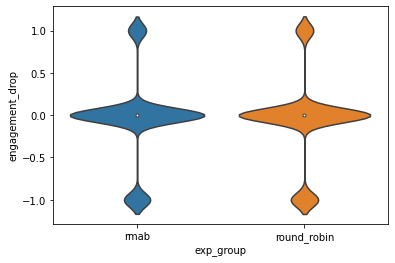

In [140]:
sns.violinplot(x='exp_group', y='engagement_drop', data=data_df)

In [142]:
pd.Series(np.array(Y_mat[t][mask['rmab']==1] - Y_mat[t-1][mask['rmab']==1] - Y_mat[0][mask['rmab']==1])).value_counts()

 0    5772
-1    1123
 1     773
dtype: int64

In [143]:
pd.Series(Y_mat[t][mask['round_robin']==1]-Y_mat[t-1][mask['round_robin']==1] - Y_mat[0][mask['round_robin']==1]).value_counts()

 0    5716
-1    1185
 1     767
dtype: int64

In [20]:
print('RMAB vs RR')
T = 10
Y_mat_df = pd.DataFrame(Y_mat[T][mask['control']==0], columns = ['output'])
X_mat_df = pd.DataFrame(X_mat[mask['control']==0][:, :-1], columns = columns[:-1])

mod = sm.OLS(Y_mat_df,X_mat_df)
fii = mod.fit()
fii.summary()


RMAB vs RR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 output   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     394.9
Date:                Wed, 18 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:54:32   Log-Likelihood:                -39061.
No. Observations:               15336   AIC:                         7.820e+04
Df Residuals:                   15299   BIC:                         7.848e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0227      0.003     -7.862      0.000      -0.028      -0.017
enroll_delivery_status    -0.6880      0.089     -7.746      0.000      -0.862      -0.514
g                          0.0541      0.061      0.889      0.374      -0.065       0.174
p                          0.0066      0.127      0.052      0.959      -0.242       0.255
s                         -0.2440      0.213     -1.148      0.251      -0.661       0.173
l                         -0.1087      0.122     -0.893      0.372      -0.348       0.130
a                         -0.1827      0.136     -1.341      0.180      -0.450       0.084
days_to_first_call         0.0027      0.003      0.879      0.379      -0.003       0.009
age_0                      0.1577      0.076      2.064      0.039       0.008       0.307
age_1                      0.0313      0.058      0.537      0.592      -0.083       0.146
age_2                      0.2000      0.063      3.168      0.002       0.076       0.324
age_3                      0.2878      0.094      3.048      0.002       0.103       0.473
age_4                      0.5238      0.188      2.792      0.005       0.156       0.891
language_2                 0.3888      0.095      4.078      0.000       0.202       0.576
language_3                 0.5024      0.097      5.199      0.000       0.313       0.692
language_4              5.981e-17   1.09e-16      0.547      0.584   -1.54e-16    2.74e-16
language_5                 0.3093      0.235      1.317      0.188      -0.151       0.770
education_1                0.0952      0.105      0.905      0.366      -0.111       0.301
education_2               -0.0498      0.063     -0.795      0.427      -0.173       0.073
education_3                0.0295      0.054      0.546      0.585      -0.076       0.135
education_4                0.1140      0.058      1.965      0.049       0.000       0.228
education_5                0.4329      0.074      5.844      0.000       0.288       0.578
education_6                0.5254      0.154      3.414      0.001       0.224       0.827
education_7                0.0535      0.095      0.564      0.572      -0.132       0.239
phone_owner_0              0.6227      0.074      8.436      0.000       0.478       0.767
phone_owner_1              0.5507      0.090      6.142      0.000       0.375       0.727
phone_owner_2              0.0271      0.164      0.165      0.869      -0.294       0.348
call_slots_1              -0.0523      0.080     -0.650      0.516      -0.210       0.105
call_slots_2               0.2310      0.082      2.828      0.005       0.071       0.391
call_slots_3               0.1846      0.050      3.714      0.000       0.087       0.282
call_slots_4               0.1650      0.065      2.541      0.011       0.038  

In [33]:
reg = LinearRegression().fit(X_mat, Y_mat)

fimp = reg.coef_
fimp = fimp.reshape((fimp.shape[0], 1))
fimp_idx = np.concatenate((fimp, np.arange(fimp.shape[0]).reshape((fimp.shape[0], 1))), axis=1)

Y_mat_df = pd.DataFrame(Y_mat, columns = ['output'])
X_mat_df = pd.DataFrame(X_mat, columns = columns)

mod = sm.OLS(Y_mat_df,X_mat_df)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values = p_values.to_list()
sorted_arr = fimp_idx[(-fimp_idx)[:, 0].argsort()]

In [219]:
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 output   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     422.7
Date:                Tue, 17 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:22:53   Log-Likelihood:                -27506.
No. Observations:               15336   AIC:                         5.509e+04
Df Residuals:                   15299   BIC:                         5.537e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
enroll_gest_age           -0.0075      0.001     -5.493      0.000      -0.010      -0.005
enroll_delivery_status    -0.2888      0.042     -6.907      0.000      -0.371      -0.207
g                          0.0214      0.029      0.747      0.455      -0.035       0.078
p                         -0.0126      0.060     -0.211      0.833      -0.130       0.104
s                         -0.1247      0.100     -1.246      0.213      -0.321       0.071
l                         -0.0250      0.057     -0.436      0.662      -0.137       0.087
a                         -0.0706      0.064     -1.102      0.271      -0.196       0.055
days_to_first_call         0.0007      0.001      0.455      0.649      -0.002       0.003
age_0                      0.0925      0.036      2.572      0.010       0.022       0.163
age_1                      0.0175      0.027      0.638      0.524      -0.036       0.071
age_2                      0.0738      0.030      2.484      0.013       0.016       0.132
age_3                      0.1092      0.044      2.458      0.014       0.022       0.196
age_4                      0.2206      0.088      2.498      0.013       0.047       0.394
language_2                 0.1482      0.045      3.302      0.001       0.060       0.236
language_3                 0.1780      0.045      3.913      0.000       0.089       0.267
language_4              6.995e-18   5.15e-17      0.136      0.892   -9.39e-17    1.08e-16
language_5                 0.1875      0.111      1.695      0.090      -0.029       0.404
education_1                0.0523      0.050      1.056      0.291      -0.045       0.149
education_2               -0.0064      0.029     -0.216      0.829      -0.064       0.051
education_3                0.0130      0.025      0.512      0.608      -0.037       0.063
education_4                0.0546      0.027      1.998      0.046       0.001       0.108
education_5                0.1956      0.035      5.610      0.000       0.127       0.264
education_6                0.2407      0.072      3.323      0.001       0.099       0.383
education_7               -0.0362      0.045     -0.811      0.417      -0.124       0.051
phone_owner_0              0.2652      0.035      7.633      0.000       0.197       0.333
phone_owner_1              0.2173      0.042      5.147      0.000       0.135       0.300
phone_owner_2              0.0312      0.077      0.404      0.686      -0.120       0.182
call_slots_1              -0.0267      0.038     -0.705      0.481      -0.101       0.048
call_slots_2               0.0801      0.038      2.081      0.037       0.005       0.155
call_slots_3               0.1026      0.023      4.386      0.000       0.057       0.148
call_slots_4               0.0552      0.031      1.804      0.071      -0.005  

In [148]:
feat_sig_df

,Feature,RMAB Group Mean,Round Robin Group Mean,Control Group Mean,Joint p-value
0,enroll_gest_age,20.323,20.454,20.325,0.472
1,stage,1.573,1.572,1.576,0.031
2,age,24.799,24.733,24.878,2.609
3,g,1.675,1.686,1.705,1.373
4,p,0.678,0.673,0.696,1.570
5,s,0.017,0.019,0.018,0.242
6,l,0.645,0.637,0.662,1.715
7,a,0.036,0.033,0.031,0.901
8,ChannelType_Community,0.707,0.727,0.723,4.356
9,ChannelType_Hospital,0.293,0.273,0.277,4.356


In [127]:
pilot_pd_data.shape

(23527, 67)

,user_id,phone_no,lmp,enroll_gest_age,project_id,manager_id,call_slots,enroll_delivery_status,delivery,language,...,phone_owner_husband,phone_owner_neighbor,phone_owner_woman,income_bracket_0-5000,income_bracket_10000-15000,income_bracket_15000-20000,income_bracket_20000-25000,income_bracket_25000-30000,income_bracket_30000 and above,income_bracket_5000-10000
0,2385610,934332f7f2dac0b09edc5572fcbcded8,2020-11-14,13,3,0,3,0,0,2,...,0,0,1,0,0,0,0,0,0,1
1,2385611,d154839aef700aeadd4aeea972ec739b,2020-11-05,14,3,0,3,0,0,2,...,0,0,1,0,0,0,0,0,0,1
2,2385612,1a1893861b32ea57cd86f2c268329995,2020-12-20,8,3,0,6,0,0,3,...,0,0,1,0,0,0,0,0,0,1
3,2385613,608ff805950471b63b183054b60bf3df,2020-11-25,11,3,0,3,0,0,3,...,0,0,1,0,0,0,0,0,0,1
4,2385614,d1fd584498c799e3fbda7d9e38f543bd,2020-07-09,31,3,0,3,0,0,2,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,2409132,9eb2c55138cc3198edef39e557e51a09,2021-01-14,8,3,0,1,0,0,3,...,0,0,1,0,0,0,0,0,0,1
23523,2409133,70ae26e929a8625fc32db522954814be,2020-06-12,39,3,0,3,0,1,2,...,0,0,1,0,1,0,0,0,0,0
23524,2409134,4b16fb66d8899412f57328a720cba0a6,2020-09-11,26,3,0,3,0,0,2,...,0,0,1,0,0,0,0,0,0,1
23525,2409135,ee32899ab102835a9a47ca2f43753089,2020-10-16,21,3,0,4,0,0,2,...,0,0,1,0,0,0,0,0,0,1


In [216]:
class_scores = defaultdict(lambda: 0)

for i in range(fimp_idx.shape[0]):
    col_name = columns[int(sorted_arr[i, 1])]
    curr_score = round(sorted_arr[i, 0], 3)
    print('{}\t{}\t{}'.format(col_name, curr_score, p_values[i]))
    if 'age_' in col_name:
        class_scores['age'] += curr_score
    if 'education_' in col_name:
        class_scores['education'] += curr_score
    if 'income_bracket_' in col_name:
        class_scores['income_bracket'] += curr_score
    if 'language_' in col_name:
        class_scores['language'] += curr_score
    if 'exp_arm_' in col_name:
        class_scores['experimental_arm'] += curr_score

print('\n\n')
for k in class_scores:
    print(k, class_scores[k])

start_state	2.777	0.0
education_6	0.167	0.0008936569608681438
income_bracket_2	0.16	1.3242264699329557e-10
ChannelType_1	0.132	2.507456779535083e-48
education_5	0.122	2.0535255235705195e-08
age_4	0.118	0.01250306266586105
phone_owner_0	0.094	2.429555092514537e-14
call_slots_5	0.09	1.2063247740052445e-07
income_bracket_3	0.084	0.00047644167089510355
phone_owner_1	0.046	2.686572948174516e-07
income_bracket_1	0.046	0.0007946016600647585
call_slots_6	0.042	6.051468363057215e-06
exp_arm_rmab	0.028	0.22896936073026117
income_bracket_4	0.022	0.12012333564062473
g	0.021	0.45490926982190616
call_slots_3	0.017	1.163562794253482e-05
language_5	0.016	0.09006411536764253
income_bracket_6	0.008	0.5060425264845194
language_3	0.007	9.159898572016126e-05
age_3	0.007	0.013997175323903611
days_to_first_call	0.001	0.6493652972553704
income_bracket_-1	0.0	0.20221672694490764
ChannelType_2	0.0	0.6394873014994227
language_4	-0.0	0.8918506605122378
call_slots_2	-0.006	0.037413139053456286
enroll_gest_age	-0.0

In [ ]:
dd